# Multi source classification

In [1]:
from itertools import combinations
import math
import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft
from collections import defaultdict
from itertools import combinations
import ast

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd
import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, multilabel_confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.models import load_model

register_matplotlib_converters()
sns.set(style='dark', palette='muted', font_scale=1)
rcParams['figure.figsize'] = 22, 10

In [2]:
# Label resolution of classification
RESOLUTION = 10

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = '../training_data/audio/multi_source'

# Number of microphones on the array
MICS_NUMBER = 6

MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

# Mean Absolute Error custom function
def mae(y_true, y_pred):
    total = 0
    
    for t, y in zip(y_true, y_pred):
        if len(y) != len(t):
            if len(t) < len(y):
                y = y[:len(t)]
            else:
                y = y + (0, ) * (len(t) - len(y))
                
        if len(y) == 1:
            total += min(abs(t[0] - y[0]), 360 - abs(t[0] - y[0]))
        else:
            c_1 = min(abs(t[0] - y[0]), 360 - abs(t[0] - y[0])) + min(abs(t[1] - y[1]), 360 - abs(t[1] - y[1]))
            c_2 = min(abs(t[0] - y[1]), 360 - abs(t[0] - y[1])) + min(abs(t[1] - y[0]), 360 - abs(t[1] - y[0]))
            
            total += min(c_1, c_2) / 2
            
    return total / len(y_true)    

### Room simulation

In [3]:
def create_simulation_room(room_dim=[4, 4, 3], mic_pos=[2, 2, 1.5], room_fs=16000):
    """
    Utility function to create a shoebox room,
    with a microphone array included.
    """
    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)

    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    mic_array_3D = np.vstack((mic_array_2D, [mic_height] * 6))
    
    # Add the microphone array to room
    room.add_microphone_array(mic_array_3D)
    
    return room

def create_sound_sources(room_dim=[4, 4, 3], resolution=1):
    """
    Function that creates a list of all audio source,
    that will be placed inside the room for simulation.
    """
    
    wall_len = room_dim[0] / 2
    
    #Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    height_range = np.linspace(0, room_dim[-1], 3)
    R = 1
   
    sources = []
    for angle in angle_range:
        for h in height_range:
            source = [R * math.cos(math.radians(angle)) + wall_len, 
                      R * math.sin(math.radians(angle)) + wall_len, h]
            sources.append((source, angle))

    return sources

def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 1.5]):
    """
    Function to simulate room with specified dimensions and microphone array position.
    Generates CSV files for all angle/distance combinations.
    
    Returns: a dictionary with all dataframes that were created.
    Keys are in a form of (angle, distance) tuples
    """
    
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    _, audio_2 = wavfile.read('../sounds/training/PinkPanther3.wav')
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        audio_2 = audio_2[-fs:]
        room_dim = TEST_ROOMS[room_type]
    
    # Create all sound sources
    sources = create_sound_sources(room_dim, 10)
    combs = len(list(combinations(sources, r=2)))
    
    i = 0
    for (source1, angle1), (source2, angle2) in combinations(sources, r=2):
        i += 1
        
        if angle1 == angle2:
            continue
            
        print(f'Simulating combination {i}/{combs}', end='\r')
        room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
        room.add_source(source1, signal=audio, delay=0.0)
        room.add_source(source2, signal=audio_2, delay=0.0)
        room.simulate()
        data = room.mic_array.signals.T
        data = np.array(normalize(data, bits=16), dtype=np.int16)
        
        save_name = f'{subset}_angles_{angle1}_{angle2}_room_{room_type}_{file_name}.wav'
        path = f'{AUDIO_PATH}/{save_name}'
        if os.path.exists(path):
            data = np.concatenate((data, wavfile.read(path)[1]))
        wavfile.write(path, fs, data)
        
    print()
    i = 0
    for source, angle in sources:
        i += 1
        
        print(f'Simulating single source {i}/{len(sources)}', end='\r')
        room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
        room.add_source(source, signal=audio, delay=0.0)
        room.simulate()
        data = room.mic_array.signals.T
        data = np.array(normalize(data, bits=16), dtype=np.int16)
        
        save_name = f'{subset}_angle_{angle}_room_{room_type}_{file_name}.wav'
        path = f'{AUDIO_PATH}/{save_name}'
        if os.path.exists(path):
            data = np.concatenate((data, wavfile.read(path)[1]))
        wavfile.write(path, fs, data)
       
    print()
    print('Simulation successful!')

In [62]:
# Simulate room for every audio file in the directory
training_sounds = os.listdir('../sounds/training')[0]
testing_sounds = os.listdir('../sounds/testing')

print('Simulating training data:\n')
for sound in training_sounds:
    for room, dim in ROOMS.items():
        # Call the function above and store all results
        print('Audio file: ' + sound)
        print(f'Room: {room}')
        simulate_room(f'../sounds/training/{sound}', 'train', room, dim / 2)
        
print('\nSimulating testing data:\n')
for sound in testing_sounds:
    for room, dim in TEST_ROOMS.items():
        # Call the function above and store all results
        print('Audio file: ' + sound)
        print(f'Room: {room}')
        simulate_room(f'../sounds/testing/{sound}', 'test', room, dim / 2)


Simulating testing data:

Audio file: StarWars1.wav
Room: small
Simulating combination 5775/5778
Simulating single source 108/108
Simulation successful!
Audio file: StarWars1.wav
Room: medium
Simulating combination 5775/5778
Simulating single source 108/108
Simulation successful!
Audio file: StarWars1.wav
Room: large
Simulating combination 5775/5778
Simulating single source 108/108
Simulation successful!


Plot the room with sources to verify correctness:

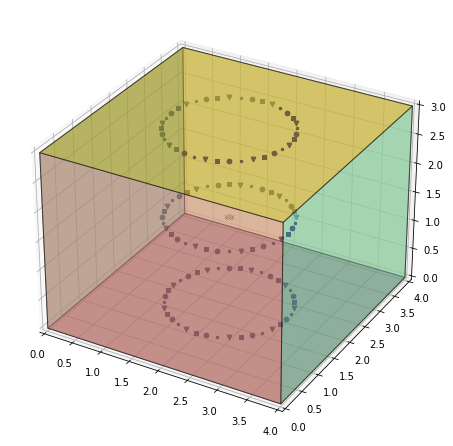

In [13]:
room_dim = ROOMS['small']

room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
sources = create_sound_sources(room_dim, resolution=10)

def plot_room(room, sources):
    fs, audio = wavfile.read("../sounds/training/CantinaBand3.wav")

    # Add every single source to the room
    for source, angle in sources:
        room.add_source(source, signal=audio, delay=0.5)

    # Plot the room
    fig, ax = room.plot()
    fig.set_size_inches(6, 6)
    ax.set_xlim([0, room_dim[0]])
    ax.set_ylim([0, room_dim[1]])
    ax.set_zlim([0, room_dim[2]]);
    
plot_room(room, sources)

### Preprocessing

In [4]:
def gcc_phat(x_1, x_2, FS=16000, interp=1):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
     # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs, interp=1):
    """
    Creates a GCC matrix, where each row is a vector of GCC 
    between a given pair of microphones.
    """ 
    
    mic_pairs = combinations(range(MICS_NUMBER), r=2)

    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    for mic_1, mic_2 in mic_pairs:
        x_1 = observation[:, mic_1]
        x_2 = observation[:, mic_2]

        gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

        # Add the GCC vector to the GCC matrix
        transformed_observation.append(gcc)    
        
    return transformed_observation


def create_observations(wav_signals, fs, labels, samples=1, step=1, resolution=20, music=False, interp=1):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row 
    is a vector of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(labels)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
        else:
            # Transform observation into a GCC matrix
            transformed_observation = compute_gcc_matrix(observation, fs, interp=interp)
            
        X.append(transformed_observation)

    return X, y


def multi_hot_encode(encoder, y_train, y_test):
    """
    Creates a multi-hot encoding of categorical labels
    provided in y_train and y_test.
    """
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test
  
    
def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['room', 'label']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['room', 'label']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = multi_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test


def create_dataframe(subset, samples=20, step=5, resolution=20, is_info=True, interp=1):
    """
    Creates a whole dataframe 
    It is achieved by looping through all WAV files in the directory
    and creating observations from each of them. 
    
    These observations are then all concatenated together 
    into one large dataframe
    
    Returns:
        a pandas dataframe containing all data points (without any splits)
    """
    
    dataframes = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if subset in file]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        
        labels = (int(file.split('_')[2]), )
        if file.split('_')[1] == 'angles':
            labels = (int(file.split('_')[2]), int(file.split('_')[3]))
            
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, labels, samples, step, resolution, interp=interp)
        
        cols = [
            f'mics{mic_1+1}{mic_2+1}_{i}' 
                for mic_1, mic_2 in combinations(range(MICS_NUMBER), r=2) 
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        
        # Add extra info columns
        if is_info:
            room = file.split('_')[5 if file.split('_')[1] == 'angles' else 4]
            df['room'] = room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

In [67]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()

df_train.to_csv('../training_data/multi_train_dataset.csv')
df_test.to_csv('../training_data/multi_test_dataset.csv')

encoder = MultiLabelBinarizer()
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
pd.set_option('display.max_columns', 15)
df_train.head(10)

train file 1998/1998
test file 1998/1998
(1126494, 15, 25) (380546, 15, 25) (1126494, 36) (380546, 36)


,mics12_0,mics12_1,mics12_2,mics12_3,mics12_4,mics12_5,mics12_6,...,mics56_20,mics56_21,mics56_22,mics56_23,mics56_24,room,label
0,-0.027586,0.003311,0.030210,-0.001501,-0.030951,0.006514,0.045004,...,0.027955,0.023540,-0.021813,-0.020964,0.016599,large,"(0, 100)"
1,-0.010687,-0.023490,0.003169,0.026683,0.002603,-0.020830,0.016916,...,0.012664,0.033597,-0.005669,-0.024821,0.005907,large,"(0, 100)"
2,-0.008281,-0.005197,0.008525,0.008912,-0.001425,0.003334,0.016377,...,0.020482,0.023745,-0.016484,-0.019391,0.014643,large,"(0, 100)"
3,-0.013351,0.005769,0.021190,0.000653,-0.019292,0.004318,0.031155,...,0.023308,0.036811,-0.009949,-0.023461,0.013421,large,"(0, 100)"
4,-0.008103,-0.014453,0.016713,0.038449,0.013066,-0.014596,0.006833,...,0.014348,0.025582,-0.013566,-0.022223,0.014369,large,"(0, 100)"
5,-0.015564,0.023405,0.014395,-0.038446,-0.034134,0.032321,0.029007,...,0.048643,0.002212,-0.053242,-0.011917,0.043013,large,"(0, 100)"
6,-0.025134,0.020711,0.015825,-0.035574,-0.025893,0.044820,0.034269,...,0.053826,0.013187,-0.045754,-0.015698,0.031945,large,"(0, 100)"
7,-0.026430,0.016962,0.014124,-0.034344,-0.028003,0.040919,0.043549,...,0.051569,0.014580,-0.039904,-0.012626,0.028465,large,"(0, 100)"
8,-0.028706,0.025750,0.021296,-0.036392,-0.029383,0.047478,0.046132,...,0.049008,0.015332,-0.035874,-0.008964,0.027856,large,"(0, 100)"
9,-0.025270,-0.001328,0.007736,0.006191,0.022949,0.051181,0.041047,...,0.060663,0.038602,-0.012408,-0.003024,0.024445,large,"(0, 100)"


Only run this when all the variables are not stored in memory (i.e. after restarting the kernel):

In [5]:
df_train = pd.read_csv('../training_data/multi_train_dataset.csv', index_col=[0], converters={"label": ast.literal_eval})
df_test = pd.read_csv('../training_data/multi_test_dataset.csv', index_col=[0], converters={"label": ast.literal_eval})
encoder = MultiLabelBinarizer()
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

C:\Users\tkhor\miniconda3\envs\dsp_env\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


((1126494, 15, 25), (380546, 15, 25), (1126494, 36), (380546, 36))

In [6]:
train_mask = []
for label in df_train.label:
    if len(label) == 1:
        train_mask.append(True)
    elif min(abs(label[0] - label[1]), (360 - abs(label[0] - label[1]))) < 30 :
        train_mask.append(False)
    else:
        train_mask.append(True)
        
test_mask = []
for label in df_test.label:
    if len(label) == 1:
        test_mask.append(True)
    elif min(abs(label[0] - label[1]), (360 - abs(label[0] - label[1]))) < 30 :
        test_mask.append(False)
    else:
        test_mask.append(True)

In [7]:
df_train = df_train[train_mask]
df_test = df_test[test_mask]
encoder = MultiLabelBinarizer()
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((1000154, 15, 25), (337854, 15, 25), (1000154, 36), (337854, 36))

In [15]:
pd.set_option('display.max_columns', 15)
df_train.head(10)

,mics12_0,mics12_1,mics12_2,mics12_3,mics12_4,mics12_5,mics12_6,...,mics56_20,mics56_21,mics56_22,mics56_23,mics56_24,room,label
0,-0.028646,0.017282,0.037868,0.000123,-0.015750,0.025812,0.026116,...,-0.004491,-0.002037,-0.038615,-0.016037,0.033766,large,"(0, 100)"
1,-0.014527,0.012831,0.023839,-0.006071,-0.013759,0.026363,0.026599,...,0.009613,0.014070,-0.030745,-0.025238,0.012012,large,"(0, 100)"
2,-0.024581,0.005924,0.025999,0.000127,-0.014921,0.017383,0.024001,...,0.000185,-0.003245,-0.035993,-0.010697,0.038133,large,"(0, 100)"
3,-0.030241,0.015002,0.036774,0.000435,-0.014613,0.023134,0.010853,...,-0.017788,-0.013415,-0.040009,-0.007348,0.043788,large,"(0, 100)"
4,-0.010878,0.008643,0.009816,-0.020590,-0.020207,0.030894,0.043697,...,0.017192,0.025656,-0.016099,-0.013448,0.019204,large,"(0, 100)"
5,-0.027865,0.018947,0.041759,0.005592,-0.012393,0.019887,0.004427,...,-0.021472,-0.021118,-0.049484,-0.010817,0.050357,large,"(0, 100)"
6,-0.026872,0.020036,0.038329,-0.001824,-0.018403,0.020769,0.014432,...,-0.020828,-0.015482,-0.040608,-0.005512,0.046314,large,"(0, 100)"
7,-0.032087,0.013940,0.040160,0.005457,-0.016397,0.012394,0.001654,...,-0.019430,-0.020365,-0.047004,-0.007854,0.049129,large,"(0, 100)"
8,-0.031004,0.024829,0.046151,0.003166,-0.017579,0.017984,0.009055,...,-0.027709,-0.017820,-0.036379,0.003157,0.055473,large,"(0, 100)"
9,-0.039269,0.004888,0.031075,0.004809,-0.007295,0.021580,0.006370,...,-0.012973,-0.014696,-0.043899,-0.017300,0.032533,large,"(0, 100)"


Plot example GCC matrices for two sources:

In [68]:
def plot_gccs(observations, labels):
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle('Example GCC matrices for different angles', fontsize=18)
    angles = [(0, 10), (0, 40), (0, 70), (0, 100)]

    for i, angle in enumerate(angles):
        ax = axs[i//2][i%2]
        indices = np.where(labels == angle)[0]
        obs_idx = indices[np.random.randint(len(indices))]

        observation = observations[obs_idx]

        ax.set_title(f'Angle {angle}')
        im = ax.matshow(observation.T, aspect=0.5)
        fig.colorbar(im, ax=ax)

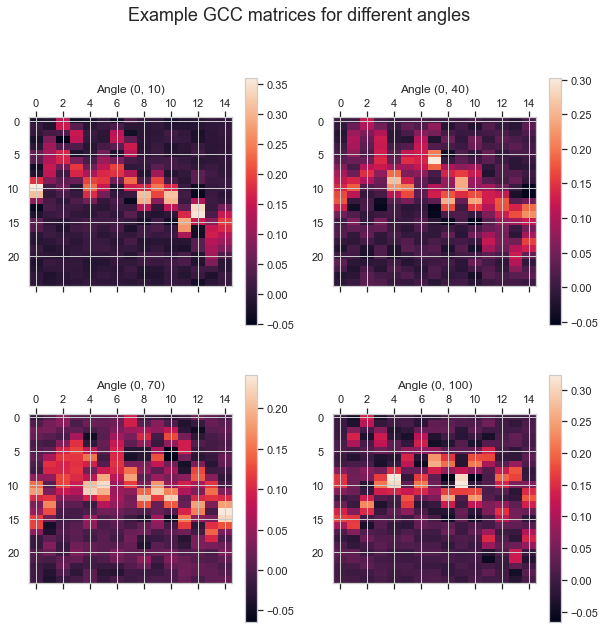

In [48]:
# Get training labels
plot_gccs(X_train, df_train.label)

### Train the baseline model

In [8]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((1000154, 25, 15), (337854, 25, 15))

In [9]:
# Fit model
epochs, batch_size, verbose = 10, 32, 1

# Fit model
def create_model(X_train, y_train, X_test, y_test, cnn_layers=2, pooling=True):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    
    for i in range(cnn_layers-1):
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        
    model.add(Dropout(0.5))
    
    if pooling:
        model.add(MaxPooling1D(pool_size=2))
        
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
model = create_model(X_train, y_train, X_test, y_test)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 23, 64)            2944      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               82048     
_________________________________________________________________
dense_3 (Dense)              (None, 36)               

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
35203/35203 [==============================] - 290s 8ms/step - loss: 0.0350
Epoch 2/10
35203/35203 [==============================] - 267s 8ms/step - loss: 0.0160
Epoch 3/10
35203/35203 [==============================] - 268s 8ms/step - loss: 0.0132
Epoch 4/10
35203/35203 [==============================] - 267s 8ms/step - loss: 0.0118
Epoch 5/10
35203/35203 [==============================] - 269s 8ms/step - loss: 0.0110
Epoch 6/10
35203/35203 [==============================] - 269s 8ms/step - loss: 0.0104
Epoch 7/10
 2831/35203 [=>............................] - ETA: 4:11 - loss: 0.0101

### Evaluate the baseline model

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
accuracy_score(y_test, model.predict(X_test, verbose=verbose).round())

11893/11893 [==============================] - 22s 2ms/step


0.5198767034734303

In [16]:
model.save("../models/multi_source_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the Lite model.
with open('../models/multi_source_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/multi_source_model\assets
INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmp4lcj_2zx\assets


In [15]:
def evaluate_for_property(df_train, df_test, model, prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = MultiLabelBinarizer()
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    # Evaluate the model on the filtered set
    X_tst = np.transpose(X_tst, axes=[0, 2, 1])
    y_pred = model.predict(X_tst).round()
    
    acc = accuracy_score(y_tst, y_pred)
    ham_acc = 1 - hamming_loss(y_tst, y_pred)
    MAE = mae(encoder.inverse_transform(y_tst), encoder.inverse_transform(y_pred))
    
    return round(acc, 3), round(ham_acc, 3), round(MAE, 3)

In [138]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    acc, _, _ = evaluate_for_property(df_train, df_test, model, 'room', room)
    print(f"{room} room accuracy: {acc}")

Room sizes
small room accuracy: 0.619
medium room accuracy: 0.6
large room accuracy: 0.591


### Run experiment with different models

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

best_accuracy = 0
best_model_specs = None

for cnn_layers in range(2, 6):
    print(f'=== Model with {cnn_layers} convolutional layers ===')
    
    for pooling in [True, False]:
        print(f"Max pooling: {pooling}")
        model = create_model(X_train, y_train, X_test, y_test, cnn_layers=cnn_layers, pooling=pooling)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        print('Evaluation:')
        accuracy = accuracy_score(y_test, model.predict(X_test, verbose=verbose).round())
        print(accuracy)

        if accuracy > best_accuracy:
            best_model_specs = (model, cnn_layers, pooling)
            best_accuracy = accuracy

    print('=====================================================\n')
    
print()
print("RESULTS:")
print(f"Best accuracy: {best_accuracy}")

best_model, best_layers, best_pooling = best_model_specs
print(f"CNN layers: {best_layers}")
print(f"Best pooling: {best_pooling}")

=== Model with 2 convolutional layers ===
Max pooling: True
Epoch 1/10
35203/35203 [==============================] - 92s 3ms/step - loss: 0.0348
Epoch 2/10
35203/35203 [==============================] - 91s 3ms/step - loss: 0.0159
Epoch 3/10
35203/35203 [==============================] - 90s 3ms/step - loss: 0.0131
Epoch 4/10
35203/35203 [==============================] - 89s 3ms/step - loss: 0.0117
Epoch 5/10
35203/35203 [==============================] - 90s 3ms/step - loss: 0.0109
Epoch 6/10
35203/35203 [==============================] - 93s 3ms/step - loss: 0.0103
Epoch 7/10
35203/35203 [==============================] - 92s 3ms/step - loss: 0.0098
Epoch 8/10
35203/35203 [==============================] - 93s 3ms/step - loss: 0.0095
Epoch 9/10
35203/35203 [==============================] - 93s 3ms/step - loss: 0.0092
Epoch 10/10
35203/35203 [==============================] - 92s 3ms/step - loss: 0.0089
Evaluation:
11893/11893 [==============================] - 11s 948us/step
0.632

### Create the model with best params

In [10]:
best_model = create_model(X_train, y_train, X_test, y_test, cnn_layers=5, pooling=True)

In [11]:
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
31255/31255 [==============================] - 187s 6ms/step - loss: 0.0261 - accuracy: 0.4877
Epoch 2/10
31255/31255 [==============================] - 181s 6ms/step - loss: 0.0086 - accuracy: 0.5048
Epoch 3/10
31255/31255 [==============================] - 186s 6ms/step - loss: 0.0070 - accuracy: 0.5022
Epoch 4/10
31255/31255 [==============================] - 182s 6ms/step - loss: 0.0063 - accuracy: 0.4972
Epoch 5/10
31255/31255 [==============================] - 184s 6ms/step - loss: 0.0059 - accuracy: 0.4877
Epoch 6/10
31255/31255 [==============================] - 181s 6ms/step - loss: 0.0055 - accuracy: 0.4878
Epoch 7/10
31255/31255 [==============================] - 181s 6ms/step - loss: 0.0053 - accuracy: 0.4948
Epoch 8/10
31255/31255 [==============================] - 176s 6ms/step - loss: 0.0051 - accuracy: 0.4905
Epoch 9/10
31255/31255 [==============================] - 180s 6ms/step - loss: 0.0050 - accuracy: 0.4850
Epoch 10/10
31255/31255 [=====================

In [13]:
accuracy_score(y_test, best_model.predict(X_test, verbose=verbose).round())

10558/10558 [==============================] - 22s 2ms/step


0.7833265256590125

In [16]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    acc, ham_acc, MAE = evaluate_for_property(df_train, df_test, best_model, 'room', room)
    print(f"{room} room accuracy: {acc} ({ham_acc} Hamming accuracy, {MAE} Mean Absolute Error)")

Room sizes
small room accuracy: 0.781 (0.99 Hamming accuracy, 7.28 Mean Absolute Error)
medium room accuracy: 0.785 (0.991 Hamming accuracy, 7.127 Mean Absolute Error)
large room accuracy: 0.785 (0.99 Hamming accuracy, 7.087 Mean Absolute Error)


In [17]:
best_model.save("../models/best_multi_source_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the Lite model.
with open('../models/best_multi_source_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/best_multi_source_model\assets
INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpdxigdhs2\assets


Run this if model is not trained in currently running kernel:

In [18]:
best_model = load_model("../models/best_multi_source_model")

In [19]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 23, 64)            2944      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 17, 64)            12352     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)            

Plot multi-label confusion matrices:

In [80]:
y_pred = best_model.predict(X_test).round()

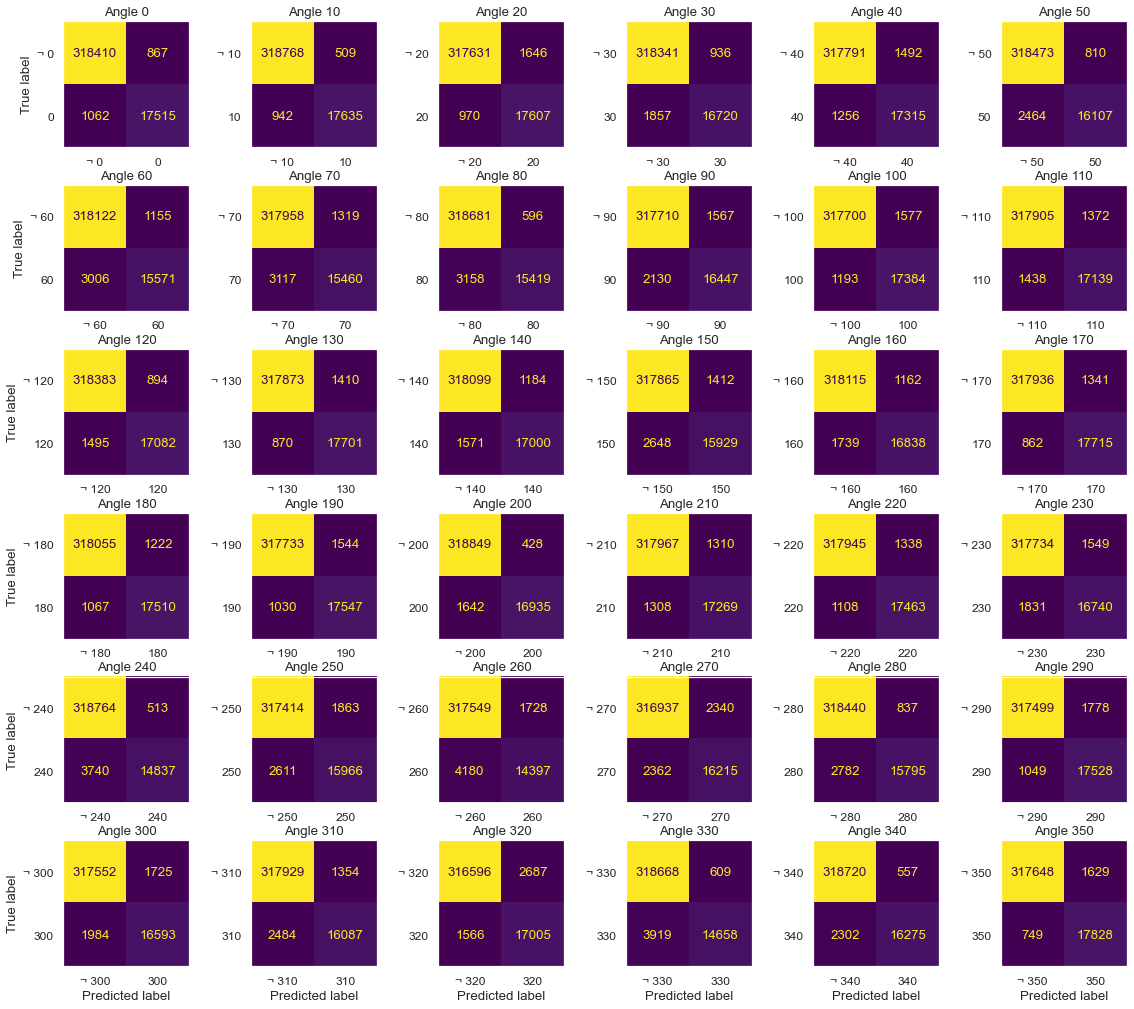

In [82]:
sns.set(font_scale=1.1)
cm = multilabel_confusion_matrix(y_test, y_pred)
f, axes = plt.subplots(6, 6, figsize=(20, 15))
axes = axes.ravel()
for i in range(36):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[f'¬ {i * 10}', i * 10])
    axes[i].grid(False)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f'Angle {i * 10}')
    disp.ax_.grid(False)
    if i<30:
        disp.ax_.set_xlabel('')
    if i%6!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.05, hspace=0.3, top=1)
plt.show()

### Compare with MUSIC baseline

In [73]:
def compute_stft_matrix(observation, nfft=256):
    """
    Creates a STFT matrix using microphone data from 6 channels.
    """
    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])


def get_doa_prediction(X, mic_pos=[2, 2, 1], resolution=20, fs=16000, nfft=256, src=1, alg='music'):
    """
    Calculates DOA based on MUSIC prediction.
    Returns:
        an angle in degrees in range 0-360 with resolution of 20
    """
    
    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    R = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    R = np.vstack((R, [mic_height] * 6))
    
    # Run MUSIC algorithm for DOA
    if alg == 'music':
        doa = pra.doa.MUSIC(R, fs, nfft, n_grid=(360 // resolution), num_src=src)
    elif alg == 'srp':
        doa = pra.doa.SRP(R, fs, nfft, n_grid=(360 // resolution), num_src=src)
        
    doa.locate_sources(X)
    
    azimuth_recon = doa.azimuth_recon
    if src == 2:
        if len(azimuth_recon) == 1:
            return round((doa.azimuth_recon[0] * 180 / math.pi)), round((doa.azimuth_recon[0] * 180 / math.pi))
        return round((doa.azimuth_recon[0] * 180 / math.pi)), round((doa.azimuth_recon[1] * 180 / math.pi))
    
    return (round((azimuth_recon[0] * 180 / math.pi)), )

def get_all_predictions(is_info=False, samples=20, step=5, resolution=20, alg='music'):
    """
    Returns a list of labels predicted by applying MUSIC.
    Observations are generated from the same test files
    that are used for CNN classification.
    
    Observation is a matrix of size (samples, channels), where
    channels is the number of microphones (6).
    """
    
    y_true = []
    y_pred = []
    info = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if 'test' in file]
    
    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        
        src = 1
        labels = (int(file.split('_')[2]), )
        if file.split('_')[1] == 'angles':
            src = 2
            labels = (int(file.split('_')[2]), int(file.split('_')[3]))
        
        # Create observations from a given WAV file
        X, y = create_observations(wav_signals, fs, labels, samples, step, resolution, True)

        room = file.split('_')[5 if file.split('_')[1] == 'angles' else 4]
        y = [(room, label) for label in y]
           
        # Store actual and predicted labels
        y_true.extend(y)
        preds = [get_doa_prediction(x, resolution=resolution, fs=fs, src=src, alg=alg) for x in X]
        y_pred.extend(preds)
        
        print(f'File {i+1}/{len(files)}', end='\r')
       
    y_true = np.array(y_true)
    
    info = y_true[:, :-1]
    y_true = y_true[:, -1]
    return y_true, np.array(y_pred), info

In [37]:
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()
binarizer = MultiLabelBinarizer()
binarizer.fit(y_true)
y_true_hot = binarizer.transform(y_true)
y_pred_hot = binarizer.transform(y_pred)
accuracy = accuracy_score(y_true_hot, y_pred_hot)
print(f'Accuracy: {round(accuracy, 3)}')

File 1998/1998
Accuracy: 0.195


In [38]:
# Hamming accuracy
ham_acc = 1 - hamming_loss(y_true_hot, y_pred_hot)
print(f'Hamming accuracy: {round(ham_acc, 3)}')
MAE = mae(y_true, y_pred)
print(f'MAE: {round(MAE, 3)}')

Hamming accuracy: 0.948
MAE: 23.064


### Compare with SRP-PHAT baseline

In [74]:
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION, alg='srp')
print()
binarizer = MultiLabelBinarizer()
binarizer.fit(y_true)
y_true_hot = binarizer.transform(y_true)
y_pred_hot = binarizer.transform(y_pred)
accuracy = accuracy_score(y_true_hot, y_pred_hot)
print(f'Accuracy: {round(accuracy, 3)}')

C:\Users\tkhor\AppData\Local\Temp/ipykernel_26236/2622213808.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array(y_true)
C:\Users\tkhor\AppData\Local\Temp/ipykernel_26236/2622213808.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return y_true, np.array(y_pred), info



Accuracy: 0.064


In [76]:
# Hamming accuracy
ham_acc = 1 - hamming_loss(y_true_hot, y_pred_hot)
print(f'Hamming accuracy: {round(ham_acc, 3)}')
MAE = mae(y_true, y_pred)
print(f'MAE: {round(MAE, 3)}')

Hamming accuracy: 0.948
MAE: 39.89
